引用元：https://www.kaggle.com/madz2000/simple-covid19-week-4-prediction-with-xgbregressor

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
#ライブラリやモジュールの読み込み
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer

import warnings
warnings.simplefilter("ignore")

## データの読み込み

In [102]:
#trainデータ、testデータ、submissionデータを読み込む
train_df = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
test_df = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")
submission = pd.read_csv("../input/covid19-global-forecasting-week-4/submission.csv")

In [4]:
#trainデータが読み込まれているか確認
train_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [5]:
#testデータが読み込まれているか確認
test_df.head()

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


## データの前処理

### 欠損値補完

In [6]:
#trainデータの欠損値を確認し集計(.isnull()でも効果は同じ)
train_df.isna().sum()

Id                    0
Province_State    20700
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64

In [7]:
#testデータの欠損値を確認し集計(.isnull()でも効果は同じ)
test_df.isna().sum()

ForecastId           0
Province_State    7740
Country_Region       0
Date                 0
dtype: int64

In [8]:
#trainデータとtestデータの欠損値を空白で埋めてデータフレームに反映させる
train_df['Province_State'].fillna("",inplace = True)
test_df['Province_State'].fillna("",inplace = True)

## Country_Regionの補正

In [9]:
#Country_Region列にProvince_State列を足して、元のProvince_State列を削除させて列を統一させる
train_df['Country_Region'] = train_df['Country_Region'] + ' ' + train_df['Province_State']
test_df['Country_Region'] = test_df['Country_Region'] + ' ' + test_df['Province_State']
del train_df['Province_State']
del test_df['Province_State']

In [11]:
#先ほどのコードが反映されているか確認
train_df.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,2020-01-26,0.0,0.0


## 年月日の分割

In [12]:
#日時に関する関数の作成

def split_date(date):
    #('-')の文字を区切りとし、年[0]、月[1]、日[2]に分割
    date = date.split('-')
    #dateの年を整数に変換
    date[0] = int(date[0])

    #二桁ある月の前の数字が0の場合
    if(date[1][0] == '0'):
        #月の二桁目の数字のみを整数とする(ex:02→2)
        date[1] = int(date[1][1])
    #二桁ある月の前の数字が1の場合
    else:
        #そのまま整数とする(ex:12→12)
        date[1] = int(date[1])

    #二桁ある日の前の数字が0の場合
    if(date[2][0] == '0'):
        #日の二桁目の数字のみを整数とする(ex:02→2)
        date[2] = int(date[2][1])
    #二桁ある日の前の数字が0以外の場合
    else:
        #そのまま整数とする(ex:12→12)
        date[2] = int(date[2])    
    
    return date

#applyはfor文のような効果がありこれによりtrainデータとtestデータのdate全体にsplit_date関数をかけている
#applyの参考：https://qiita.com/hisato-kawaji/items/0c66969343a196a65cee
train_df.Date = train_df.Date.apply(split_date)
test_df.Date = test_df.Date.apply(split_date)

In [13]:
#先ほどのコードが反映されているか確認
train_df.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,"[2020, 1, 22]",0.0,0.0
1,2,Afghanistan,"[2020, 1, 23]",0.0,0.0
2,3,Afghanistan,"[2020, 1, 24]",0.0,0.0
3,4,Afghanistan,"[2020, 1, 25]",0.0,0.0
4,5,Afghanistan,"[2020, 1, 26]",0.0,0.0


In [14]:
#year,month,dayそれぞれのリストを作成
#trainデータのDateをyear,month,dayのリストにそれぞれ格納していく

year = []
month = []
day = []
for i in train_df.Date:
    year.append(i[0])
    month.append(i[1])
    day.append(i[2])

In [15]:
#先ほど作ったリストをデータフレームに加え、Date列を削除

train_df['Year'] = year
train_df['Month'] = month
train_df['Day'] = day
del train_df['Date']

In [16]:
#先ほどtrainデータで行った事をtestデータでも行っていく

year = []
month = []
day = []
for i in test_df.Date:
    year.append(i[0])
    month.append(i[1])
    day.append(i[2])

In [17]:
test_df['Year'] = year
test_df['Month'] = month
test_df['Day'] = day
del test_df['Date']
del train_df['Id']
del test_df['ForecastId']

In [18]:
#先ほどのコードが反映されているか確認

train_df.head()

,Country_Region,ConfirmedCases,Fatalities,Year,Month,Day
0,Afghanistan,0.0,0.0,2020,1,22
1,Afghanistan,0.0,0.0,2020,1,23
2,Afghanistan,0.0,0.0,2020,1,24
3,Afghanistan,0.0,0.0,2020,1,25
4,Afghanistan,0.0,0.0,2020,1,26


In [19]:
test_df.head()

,Country_Region,Year,Month,Day
0,Afghanistan,2020,4,2
1,Afghanistan,2020,4,3
2,Afghanistan,2020,4,4
3,Afghanistan,2020,4,5
4,Afghanistan,2020,4,6


In [20]:
#Year列のユニーク値(種類)を調べてみる

train_df.Year.unique(),test_df.Year.unique()

(array([2020], dtype=int64), array([2020], dtype=int64))

In [21]:
#Year列には[2020]しか含まれていない事が分かったので削除する

del train_df['Year']
del test_df['Year']

## 目的変数と説明変数を分割

In [22]:
#trainデータのConfirmedCasesとFatalitiesをそれぞれ整数にする

train_df['ConfirmedCases'] = train_df['ConfirmedCases'].apply(int)
train_df['Fatalities'] = train_df['Fatalities'].apply(int)

In [23]:
#trainデータのConfirmedCasesをcases,Fatalitiesをfatalitiesと変数に格納しtrainデータの列からは削除する

cases = train_df.ConfirmedCases
fatalities = train_df.Fatalities
del train_df['ConfirmedCases']
del train_df['Fatalities']

## ラベルエンコード

In [27]:
#LabelEncoder()は，文字列や数値で表されたラベルを，0~(ラベル種類数-1)までの数値に変換してくれるもの
#LabelEncoderを使いCountry_Regionを国名ではなくナンバリングしていく

lb = preprocessing.LabelEncoder()
train_df['Country_Region'] = lb.fit_transform(train_df['Country_Region'])
test_df['Country_Region'] = lb.transform(test_df['Country_Region'])

<AxesSubplot:>

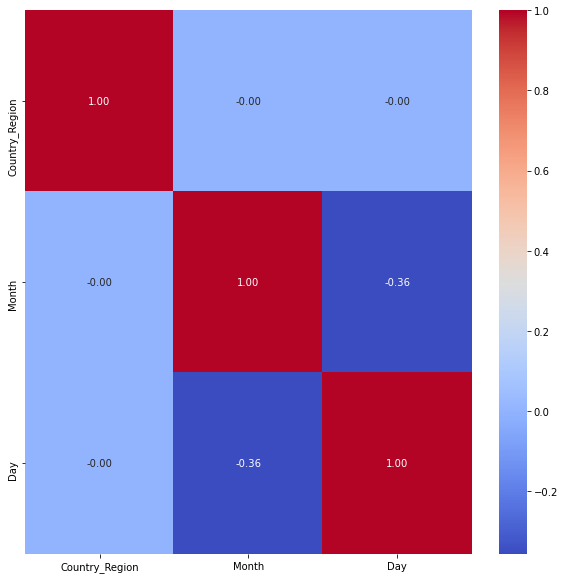

In [30]:
#matplotlibを使いデータを可視化する

plt.figure(figsize = (10,10))
corr = train_df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap = "coolwarm", annot = True, fmt = ".2f")

## 正規化

In [33]:
#trainデータとtestデータの数値を正規化(0〜1の範囲へ変換)する
#MinMaxScalerの参考：https://qiita.com/Qiitaman/items/c94420e8b86aae5f28a9

scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_df.values)
x_test = scaler.transform(test_df.values)

# モデル作成

## ConfirmedCasesに対するモデル作成

In [34]:
#XGBRegressorをインポートする

from xgboost import XGBRegressor

In [35]:
#モデルにXGRegressorを使う
#n_estimatorsは構築する決定木の本数
#random_stateを設定する事により何度実行しても同じランダムを出してくれる（結果が毎回変わらないようにする）
#max_depthは決定木の深さを決める数値
#trainデータとcasesをフィッティングさせモデルを学習させる

rf = XGBRegressor(n_estimators = 2500 , max_depth = 27, random_state = 0 )
rf.fit(x_train,cases)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=27,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## ConfirmedCasesに対する予測

In [38]:
#先ほど学習させたモデル(rf)でtestデータから予測する

cases_pred = rf.predict(x_test)
cases_pred

array([272.99905 , 281.0004  , 299.00058 , ...,  36.00076 ,  36.99918 ,
        37.001465], dtype=float32)

In [39]:
#予測したデータを小数点以下四捨五入する

cases_pred = np.around(cases_pred,decimals = 0)
cases_pred

array([273., 281., 299., ...,  36.,  37.,  37.], dtype=float32)

## Fatalitiesに対するモデル作成

In [40]:
#先ほど変数にしたcasesをx_train_casにリストとして格納していく

x_train_cas = []
for i in range(len(x_train)):
    x = list(x_train[i])
    x.append(cases[i])
    x_train_cas.append(x)
    
#格納されているか１つ目のリストを表示して確認する
x_train_cas[0]

[0.0, 0.0, 0.7, 0]

In [41]:
#x_train_casをnumpy配列に変換する

x_train_cas = np.array(x_train_cas)

In [42]:
#x_train_casとfatalitiesを使ってモデルに学習させる

rf = XGBRegressor(n_estimators = 2500  , max_depth = 27, random_state = 0)
rf.fit(x_train_cas,fatalities)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=27,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Fatalitiesに対する予測

In [43]:
#testデータもtrainデータ同様にリスト化する

x_test_cas = []
for i in range(len(x_test)):
    x = list(x_test[i])
    x.append(cases_pred[i])
    x_test_cas.append(x)
    
#格納されているか１つ目のリストを表示して確認する
x_test_cas[0]

[0.0, 0.75, 0.03333333333333333, 273.0]

In [44]:
#x_train_casをnumpy配列に変換する

x_test_cas = np.array(x_test_cas)

In [45]:
#学習させたモデル(rf)でtestデータから予測する

fatalities_pred = rf.predict(x_test_cas)
fatalities_pred

array([6.000111 , 6.000784 , 6.9994397, ..., 4.0001082, 3.9996495,
       3.9996495], dtype=float32)

In [46]:
#予測したデータを小数点以下四捨五入する

fatalities_pred = np.around(fatalities_pred,decimals = 0)
fatalities_pred

array([6., 6., 7., ..., 4., 4., 4.], dtype=float32)

# SUBMIT用ファイルを作成

In [47]:
#予測結果であるcases_predとfatalities_predの二つをsubmissionファイルの列に加える

submission['ConfirmedCases'] = cases_pred
submission['Fatalities'] = fatalities_pred

In [48]:
#コードが反映されているか確認

submission.head()

,ForecastId,ConfirmedCases,Fatalities
0,1,273.0,6.0
1,2,281.0,6.0
2,3,299.0,7.0
3,4,349.0,7.0
4,5,367.0,11.0


In [140]:
#submissionファイルを行番号を無しでcsvファイルにする。

submission.to_csv("submission.csv" , index = False)